# Demo for JAX use

**Kernel locally : jaxkernel**

In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import jacfwd, jacrev, hessian
from jax.ops import index, index_update
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 18
mpl.rcParams["font.family"] = "Times New Roman"

In [2]:
#pip install --upgrade "jax[cpu]"

In [3]:
jax.__version__

'0.2.24'

# Premiers pas

Dans un premier temps, si ce n’est pas déjà fait pour vous par le système, il faut
s’installer une version 10 de la librairie via
       pip i n s t a l l −−upgrade jax j a x l i b
Dans ce contexte seule la version CPU s’exécutera par la suite. Pour obtenir la version
GPU, il est préférable de se renseigner sur la version de CUDA en vigueur, puis faire par
exemple au CCIn2p3:
       pip i n s t a l l −−upgrade jax j a x l i b ==0.1.71+cuda102 −f
       
https : / / s t o r a g e . g o o g l e a p i s . com/ jax−r e l e a s e s / j a x_r e l e a s e s . html

Notez qu’outre la partie JAX, j’ai importé également les 2 librairies traditionnelles d’un
utilisateur lambda. L’extension Numpy de JAX n’est pas un simple "enrobage" mais les
mêmes APIs permettent d’utiliser aussi facilement la version JAX pour la quasi-totalité
des fonctions. Créons deux vecteurs par exemple

In [4]:
x = np.linspace(0 ,1 ,10) 
y = jnp.linspace(0 ,2 ,10)

A part le "j", rien ne différencie les deux lignes qui définissent les deux vecteurs x et y. Ce
qui change donc c’est leurs représentations internes:

In [5]:
x,y

(array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
        0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
 DeviceArray([0.        , 0.22222222, 0.44444445, 0.6666667 , 0.8888889 ,
              1.1111112 , 1.3333334 , 1.5555556 , 1.7777778 , 2.        ],            dtype=float32))

Numpy. Notez que le type par défaut est float32, si besoin pour passer en 64-bits il faut
procéder à l’édition d’une variable d’environnement avant l’importation des librairies 11

         import os
         os.environ [ 'JAX_ENABLE_X64 ' ]= 'True '

Les DeviceArrays permettent à JAX de procéder aux suivis des dépendances des variables
et l’optimisation du code pour les différents types de hardwares.
Une chose qui peut dérouter le premier contact avec les DeviceArrays de JAX quand
on est habitué à la librairie Numpy, est la chose suivante que l’on peut constater avec les
vecteurs x et y définis ci-dessus. S’il est simple de changer le signe de x[1] par contre si
l’on fait

In [6]:
#y[1] *= -1

alors on tombe sur une erreur

La solution immédiate est de bien entendu d’aller lire la page web suggérée. Ainsi, on
trouve la solution suivante

In [7]:
y = y.at[1].mul(-1)

In [8]:
y

DeviceArray([ 0.        , -0.22222222,  0.44444445,  0.6666667 ,
              0.8888889 ,  1.1111112 ,  1.3333334 ,  1.5555556 ,
              1.7777778 ,  2.        ], dtype=float32)

Mais si la syntaxe est rébarbative, c’est pour la simple est bonne raison que les tableaux
DeviceArrays sont des immutables (ie. ne peuvent être modifiés une fois créés), ce qui
suggère qu’il faut sans doute penser autrement la manipulation des tableaux. Il en est de
même avec les fonctions, lesquelles pour JAX doivent être des fonctions sans effets de bords
(ce qui entre parenthèses n’est pas plus mal pour éviter des chausse-trapes pythonesques).

Une fois passer cette difficulté, on peut employer les DeviceArrays comme on le fait
avec les tableaux Numpy par exemple comme arguments de fonctions matplotlib:

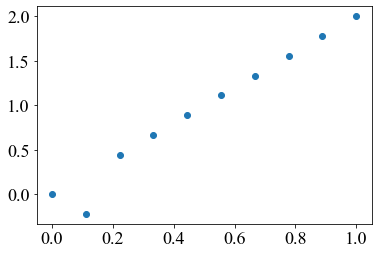

In [9]:
plt.scatter(x,y)

# Variations autour d'une fonction simple

Avec un logiciel symbolique, il est simple d’obtenir les expressions des dérivées successives
f0(x) et f00(x), que je ne donne pas mais qui sont notées fp(x) et fpp(x) dans le listing
ci-dessous. Avec JAX certes les expressions analytiques ne sont pas accessibles, mais il est
très simple par contre d’obtenir les graphes de ces fonctions (Fig. 1):

$$
f(x)= e^{-x/2}\sin(x)
$$

## Dérivées successives

In [10]:
def f(x):
    return jnp.exp(-x*0.5)*jnp.sin(x)

In [11]:
def fp(x):
    return jnp.exp(-x*0.5)*(2.*jnp.cos(x)-jnp.sin(x))/2.
def fpp(x):
    return -jnp.exp(-x*0.5)*(4.*jnp.cos(x)+3.*jnp.sin(x))/4.

In [12]:
jfp  = jax.vmap(lambda t:grad(f)(t))
jfpp = jax.vmap(lambda t:grad(grad(f))(t))

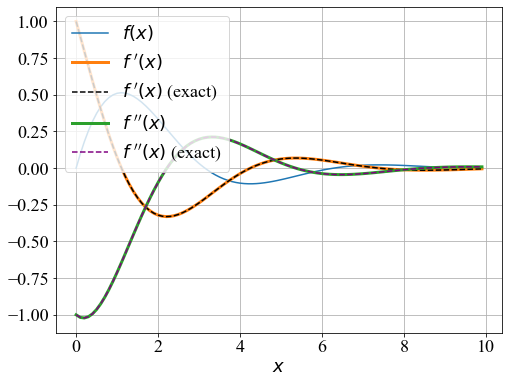

In [13]:
fig,_ = plt.subplots(figsize=(8,6))
x=jnp.arange(0,10,0.1)
plt.plot(x,f(x), label="$f(x)$")
plt.plot(x,jfp(x), lw=3,label="$f^{\ \prime}(x)$")
plt.plot(x,fp(x),ls="--",c='k', label="$f^{\ \prime}(x)$ (exact)")
plt.plot(x,jfpp(x), lw=3,label="$f^{\ \prime\prime}(x)$")
plt.plot(x,fpp(x),ls="--", c='purple',label="$f^{\ \prime\prime}(x)$ (exact)")
plt.grid()
plt.xlabel("$x$")
plt.legend();

Figure 1 – Exemple de l’utilisation de la différentiation automatique pour calculer les
dérivées successives d’une fonction de la variable x. On également présentés les graphes
des fonctions dérivées dont les expressions analytiques sont connues.

Notez que j’utilise deux fonctions de la librairie JAX: la fonction grad qui calcule le gradient
de la fonction par rapport à la variable x que l’on peut itérer pour obtenir les dérivées
successives, et la fonction vmap qui permet d’appliquer la fonction sur des valeurs rangées
dans un tableau (batching). Il y a une autre fonction similaire jax.numpy.vectorize qui
a la même API que la version Numpy, mais elle est codée plutôt dans l’esprit de vmap. Les
règles de vectorisation ne sont pas les mêmes et donc il faut déjà savoir ce que l’on veut
faire en pratique. Il serait trop long d’établir un "how-to" ici 12, et donc je vous renvoie à
la doc 13, et exemples de codes que l’on trouve sur le Web.
A la différence d’une méthode de différences finies qui calcule une approximation
des dérivées comme par exemple:

$$
f^\prime(x) \simeq \frac{f(x+h)-f(x)}{h}
$$

avec $h$ suffisamment petit, JAX analyse le schéma de dépendance de $f$ vis-à-vis de $x$ directement
à partir du code. On obtient alors une estimation aussi précise que le calcul
analytique sans pour autant mener à bien le calcul. Bien entendu, on utilise la différentiation
automatique dans des situations où le calcul ne peut pas être mené.

## Fit simple par la méthde de descente de gradient

Imaginons à présent que l’on paramètrise la fonction f(x) selon
$$
f(p,x)=e^{-p_0x}\sin(p_1x)
$$

et que l’on cherche à trouver les valeurs de $p_0$ et $p_1$ en disposant de mesures bruitées
${x_i, y_i}$ tel que ${i<N}$. En utilisant simplement pour le moment Numpy on peut générer les échantillons,
en définissant $g(x) = f(ptrue, x)$ on a le code suivant:

In [14]:
def f(p,x):
    return jnp.exp(-x*p[0])*jnp.sin(x*p[1])

In [15]:
xcont=np.linspace(0,1,100)
y

DeviceArray([ 0.        , -0.22222222,  0.44444445,  0.6666667 ,
              0.8888889 ,  1.1111112 ,  1.3333334 ,  1.5555556 ,
              1.7777778 ,  2.        ], dtype=float32)

In [16]:
ptrue = np.array([0.5,1])
ftrue = lambda x: f(ptrue, x)

In [17]:
xin = np.arange(0,10,1.)
yerr = 0.05
yin = ftrue(xin)+np.random.normal(scale=yerr,size=xin.shape)

In [18]:
xcont=np.linspace(0,10,100)
ycont=ftrue(xcont)

Text(0, 0.5, 'y')

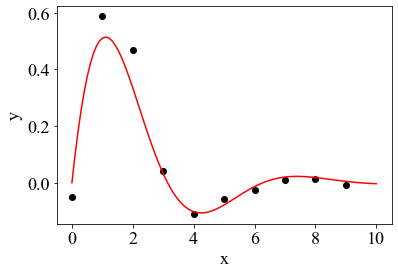

In [19]:
plt.plot(xin,yin,'ko')
plt.plot(xcont,ycont,'r-')
plt.xlabel("x")
plt.ylabel("y")

Afin d’obtenir l’estimation des paramètres pest, on se définit alors un modèle qui correspond
à la définition de $f(p, x)$ et nous donne pour chaque couple de paramètres les
valeurs des $y_i = f(p, x_i)$. Ensuite, il nous faut un fonction de coût (risque empirique, loss)
à minimiser. Là encore pas de surprise, nous allons utiliser la MSE (mean square error,
ou méthode des moindres carrés):

In [20]:
def model(p, xi):
    return f(p,xi)

def mse(y_hat, y):
    return jnp.power(y_hat - y, 2).mean()

def loss_fun(p, xi, yi):
    yhat = model(p, xi)
    return mse(yhat, yi)

Il nous reste alors à procéder à l’estimation d’un pas de **descente de gradient** pour lequel
on utilise la différentiation automatique:

In [21]:
@jit
def gradient_descent_step(p, xi, yi, lr=1e-1):
    return p - lr * jax.grad(loss_fun)(p, xi, yi)

Notons que par défaut $jax.grad$ opère sur le premier argument de la fonction à différentier
mais cela est bien entendu ajustable:

### Function of 2 variables

In [22]:
def func(x, y):
    return 2 * x * y

print(grad(func)(3., 4.))  # 8.
print(grad(func, argnums=0)(3., 4.))  # 8.
print(grad(func, argnums=1)(3., 4.))  # 6
print(grad(func, argnums=(0, 1))(3., 4.))  # (8., 6.)

8.0
8.0
6.0
(DeviceArray(8., dtype=float32), DeviceArray(6., dtype=float32))


In [23]:
print(grad(func, argnums=(0, 1))(3., 4.)) 

(DeviceArray(8., dtype=float32), DeviceArray(6., dtype=float32))


qui plus est la fonction peut être complexe (ie. holomorphe). Bien, finalement le code qui
permet d’obtenir une estimation des paramètres s’écrit comme suit:

## Descente de gradient

In [24]:
p_cur = jnp.array([0., 0.5])
rel_err=np.nan
for t in range(1000):

    if (t % 100) == 0:
        print(t, p_cur,rel_err)

    new_p = gradient_descent_step(p_cur, xin,yin)

    rel_err = jnp.sqrt(jnp.mean((p_cur - new_p)**2))
    if rel_err < 1e-9:
        print(f"Converged after {t} epochs: p = {new_p}")
        break

    p_cur = new_p

0 [0.  0.5] nan
100 [0.4512081  0.88514286] 0.0017672799
200 [0.4154175 0.9745982] 0.00014208998
300 [0.41420448 0.9812115 ] 9.020804e-06
400 [0.4141692 0.9816371] 5.915592e-07
500 [0.4141679 0.9816641] 4.2146848e-08
Converged after 515 epochs: p = [0.4141679 0.981665 ]


## Méthode de Newton: le Hessien

On peut utiliser la méthode de Newton
qui fait appel au hessien de la fonction de coût (ie. matrice des dérivées secondes) selon
l’opération
$$
p_{n+1} = p_n  −  \lambda(\nabla_p^2 L(p_n))^{—1}\nabla_p L(p_n)
$$

In [25]:
gLoss = lambda p,xi,yi: jacfwd(loss_fun)(p,xi,yi)
hLoss = lambda p,xi,yi: jax.hessian(loss_fun)(p,xi,yi)

In [26]:
@jit
def oneStepNewton(p,xi,yi,lr=0.1):
    return p - lr*jnp.linalg.inv(hLoss(p,xi,yi)) @ gLoss(p,xi,yi)

Notons l’usage de la fonction $jacfwd$, elle calcule le jacobien de la fonction entre "()"
par rapport au premier argument, mais ce dernier peut-être un vecteur tandis que grad
devrait être vectorisée pour cela. A coté de $jacfwd$ (forward), il y a la fonction $jacrev$
(backward) et toutes les deux calculent le jacobien, mais la première est plutôt dédiée
pour matrice à grand nombre de lignes tandis que la seconde est taillée pour les matrices
à grande nombre de colonnes. Ainsi, pour plus d’efficacité c’est pour cette raison que la
fonction $jax.hessian(f)$ est codée selon $jacfwd(jacrev(f))$, ce qui serait une autre
façon de coder $hLoss$.

Maintenant, en utilisant $oneStepNewton$ en lieu et place de gradient_descent_step,
alors on obtient une convergence plus rapide:

In [27]:
p_cur = jnp.array([0., 0.5])
rel_err=np.nan
for t in range(5000):

    if (t % 100) == 0:
        print(t, p_cur,rel_err)

    new_p = oneStepNewton(p_cur, xin,yin)

    rel_err = jnp.sqrt(jnp.mean((p_cur - new_p)**2))
    if rel_err < 1e-9:
        print(f"Converged after {t} epochs: p = {new_p}")
        break

    p_cur = new_p

0 [0.  0.5] nan
100 [0.04078362 3.14156   ] 0.0008627418
200 [0.02897805 3.1415915 ] 1.0536712e-08
Converged after 207 epochs: p = [0.028978  3.1415915]


Notez au passage l’usage de la librairie d’algèbre linéaire de JAX et l’usage de l’opérateur
Python "@" pour la multiplication matricielle.

# Un autre type d'optimisation

Le type de problème d’optimisation de la section précédente se présente dans beaucoup
de domaines via les méthodes lagrangiennes. Par exemple, trouver les dimensions
d’un pavé 3D dont la surface totale des cotés vaut par exemple 24, et pour lequel on veut
maximiser le volume. Cela se résout en remplaçant la fonction de coût par le lagrangien
suivant

$$
{\cal L}(x,y,z,\alpha)= V(x,y,z) - \alpha(S(x,y,z) - 24)
$$

$$
V(x,y,z)=xyz \\
S(x,y,z)=2(xy+xy+yz)
$$

In [28]:
# Volume de la boite 
def vol(x): 
    return x[0]*x[1]*x[2]
# Surface de la boite
def surf(x):
    return 2.*(x[0]*x[1]+x[0]*x[2]+x[1]*x[2])
# Constrainte sur la surface
def g(x): return surf(x) - 24

#Lagrangien : p[0:3] = (x1,x2,x3), p[3] = multiplicateur de lagrange
def Lag(p): 
    return vol(p[0:3]) - p[3]*g(p[0:3])

In [29]:
#Gradient Lagrangien
gLag = jacfwd(Lag)
hLag = hessian(Lag)

In [30]:
@jit
def solveLagrangian(p,lr=0.1): 
    return p - lr*jnp.linalg.inv(hLag(p)) @ gLag(p)

Enfin, résoudre l’équation $ \nabla {\cal L} = 0 $ à la recherche du point critique se fait via

In [31]:
p_cur = jnp.array([1.5,0.5,1.0,0.1])

for t in range(200):

    if (t % 10) == 0:
        print(t, p_cur)

    new_p = solveLagrangian(p_cur)
    
    rel_err = jnp.max(jnp.abs(p_cur - new_p))
    if rel_err < 1e-6:
        print(f"Converged after {t} epochs")
        break
    
    p_cur = new_p

p_fin=p_cur
v_fin = vol(p_fin[0:3])
s_fin = surf(p_fin[0:3])

print("p_fin: ",p_fin,": True x=y=z=2, lambda=0.5" )
print("v_fin: ",v_fin,": True vol  = 2^3")
print("s_fin: ",s_fin,": True surf = 24")

0 [1.5 0.5 1.  0.1]
10 [1.8335831  1.5516778  1.7771688  0.40679324]
20 [1.9443338 1.8488717 1.9288241 0.4698166]
30 [1.9808732  1.9478556  1.9758339  0.48971188]
40 [1.9933648  1.9818826  1.9916483  0.49643993]
50 [1.9976907  1.9936905  1.9970968  0.49876192]
60 [1.9991952  1.997801   1.9989886  0.49956873]
70 [1.9997195  1.9992332  1.9996475  0.49984968]
80 [1.9999021  1.9997327  1.9998771  0.49994758]
90 [1.9999659  1.9999067  1.9999571  0.49998173]
100 [1.9999882  1.9999673  1.999985   0.49999362]
110 [1.999996   1.9999887  1.9999948  0.49999774]
Converged after 112 epochs
p_fin:  [1.9999967  1.9999908  1.9999957  0.49999818] : True x=y=z=2, lambda=0.5
v_fin:  7.999933 : True vol  = 2^3
s_fin:  23.999866 : True surf = 24


Même si on peut se rendre compte que l’environnement du point scelle solution n’est pas
très bien "marqué", on peut tuner le learning rate pour mener à bien la minimisation, si ce
n’est pas le cas il faut un peut tâtonner. Cependant, même dans cet exercice où l’optimisation
est simple, on peut se demander s’il n’y a pas une sensibilité de la solution trouvée
par rapport aux valeurs initiales que l’on donne (ie. la première valeur des paramètres
p_cur). Bien entendu, on peut le faire à la main via une fonction qui prend en argument
les valeurs initiales des paramètres que l’on tire au hasard. Mais, on peut le faire faire
(plus efficacement 14) par JAX aussi!

La première chose à faire est de vectoriser la fonction $solveLagrangian$ pour quelle
accepte plusieurs vecteurs p_cur à l’initialisation, et quelle puisse les mettre à jour en
même temps:

              vfuncsLAG = vmap( solveLagrangian )
              


In [32]:
@jit
def solveLagrangian(p,lr=0.1): 
    return p - lr*jnp.linalg.inv(hLag(p)) @ gLag(p)

In [33]:
vfuncsLAG = vmap(solveLagrangian)

Ensuite, il faut pouvoir tirer aléatoirement les dites valeurs initiales. Pour se faire JAX a
une routine ad hoc $jax.random.PRNGKey(seed)$ pour garantir la génération de nombres
aléatoires reproductible, vectorisable et parallélisable. Ainsi, on utilise le code suivant pour
générer 100 vecteurs $p_{cur}$ (de dimension 4), qui je pense est assez clair:


              key = jax.random.PRNGKey(0)
              p_cur = jax.random.uniform(key ,shape=(100 ,4),dtype='float32',minval=0.,maxval=1.0)

In [34]:
key = jax.random.PRNGKey(0)
p_cur = jax.random.uniform(key, shape=(100,4), dtype='float32', minval=0., maxval=1.0)

In [35]:
p_cur[:10]

DeviceArray([[0.7455205 , 0.5724256 , 0.5989009 , 0.40756226],
             [0.7306458 , 0.9552475 , 0.4196427 , 0.52214766],
             [0.02199447, 0.1088649 , 0.2846495 , 0.74595153],
             [0.4045459 , 0.42050242, 0.5038254 , 0.7700802 ],
             [0.16906488, 0.59770143, 0.44737732, 0.83202744],
             [0.5080929 , 0.5435822 , 0.5909877 , 0.2801602 ],
             [0.7243432 , 0.32554698, 0.68651915, 0.7910842 ],
             [0.14363754, 0.4956231 , 0.9737681 , 0.4505446 ],
             [0.28138304, 0.6602762 , 0.8740549 , 0.41414762],
             [0.9935266 , 0.76060784, 0.11353779, 0.0050137 ]],            dtype=float32)

In [36]:
for t in range(3000):
    p_cur = vfuncsLAG(p_cur)

pour obtenir à l’étape finale 100 jeux de paramètres. Pour déterminer le meilleur, on utilise
la fonction vol pour déterminer le jeu qui réalise le volume maximal. Pour se faire on
utilise la fonction $nanargmax$ de $jax.numpy$ qui fonctionne comme son pendant de Numpy:

In [37]:
maxfunc  = jax.vmap(vol)
maximums = maxfunc(p_cur)

In [38]:
arglist = jnp.nanargmax(maximums)
argmax = p_cur[arglist]
maxvol = maximums[arglist]
print(f"The max. volume is {maxvol:.6f}, the lengthes are ({argmax[0]:.6f},{argmax[1]:.6f},{argmax[2]:.6f})")

The max. volume is 8.000007, the lengthes are (2.000001,2.000001,2.000000)


On obtient alors si on a ’bien’ choisi le learning rate et suffisamment d’itérations

    The max . volume i s 8.000013 , the l eng the s are ( 2 . 0 0 0 0 0 1 , 2 . 0 0 0 0 0 1 , 2 . 0 0 0 0 0 1 )


Encore une fois si le problème est mal conditionné, ce n’est pas JIT qui sauvera sa résolution.
Bien entendu des choses plus complexes sont possibles, en particulier le sampling
de densités de probabilités par méthodes Monte Carlo de type MCMC Hamiltonien que
j’aborderai dans une autre note à venir.

# JIT: quelques exemples
Une chose qu'il est possible de faire pour se rendre compte de l'effet de JIT c'est de commenter dans les cellules précédentes les lignes "@jit" (décorateur Python) et de réexecuter le notebook.

Tout au long des exemples précédents, il y avait des lignes "@jit", il s’agit d’un
décorateur Python qui appelle l’optimisation du code par son traitement par XLA. JIT
permet de produire un code "optimisé" pour le hardware utilisé, essentiellement CPU et
GPU/Nvidia (ie. le TPU est très spécifique). Une première idée de ce que peut apporter la
compilation peut être touché du doigt en commentant les lignes "@jit" dans le notebook et
en le ré-exécutant. Le gain de l’usage de la compilation est suffisamment significatif pour
qu’il soit "visible" même sur un CPU. Ce n’est pas toujours le cas. Voyons par exemple
un code purement en Numpy qui calcule par approximation de Simpson des intégrales d’un
lot de 200 fonctions de type

$$
fn(x) = x^{n/10}e^{−x}
$$

sur 100 intervalles:

In [39]:
def simps(f, a, b, N):
    #N doit etre paire
    dx = (b - a) / N
    x = np.linspace(a, b, N + 1)
    y = f(x)
    w = np.ones_like(y)
    w[2:-1:2] = 2.
    w[1::2]   = 4.
    S = dx / 3 * np.einsum("i...,i...",w,y)
    return S

In [40]:
def funcN(x):
    return np.stack([x**(i/10) * np.exp(-x) for i in range(200)],axis=1)

In [41]:
a = np.arange(0,10,0.1)

In [42]:
b=a+0.05

In [43]:
%timeit simps(funcN,a,b, 512)

585 ms ± 69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
x_test = np.random.normal(loc=10,size=(3,100))

In [45]:
%timeit funcN(x_test)

4.71 ms ± 806 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [46]:
def test_funcN(x):
    x = x[:, None, :]
    i = np.arange(200)[:, None]
    return x**(i/10) * np.exp(-x)

In [47]:
%timeit test_funcN(x_test)

3.01 ms ± 1.05 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [48]:
from functools import partial
from jax.config import config
config.update("jax_enable_x64", True)

In [49]:
@partial(jit, static_argnums=(0,3))
def jax_simps(f, a,b, N):
    dx = (b - a) / N
    x = jnp.linspace(a, b, N + 1)
    y = f(x)
    w = jnp.ones_like(y)
    w = w.at[2:-1:2].set(2.)
    w = w.at[1::2].set(4.)
    S = dx / 3. * jnp.einsum('i...,i...',w,y)
    return S

In [50]:
@jit
def jax_funcN(x):
    return jnp.stack([x**(i/10) * jnp.exp(-x) for i in range(200)],axis=1)

In [51]:
ja = jnp.arange(0,10,0.1)
jb = ja+0.05

La première chose spécifique à la comparaison ici entre Numpy et JAX est le fait que l’on
exige de travailler en double précision qui est le fonctionnement par défaut de Numpy.
Ensuite, on remarque les décorateurs Python "@partial" et "@jit": ce sont juste des
raccourcis. En effet, je pouvais très bien écrire

In [52]:
tmp1 = jax_simps(jax_funcN,ja,jb, 512).block_until_ready() 
%timeit jax_simps(jax_funcN,ja,jb, 512).block_until_ready() 

573 ms ± 60.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


       jit_funcN = jax.jit(jax_funcN)

qui permet d’utiliser la fonction compilée $jit\_funcN(x)$, mais le décorateur permet d’utiliser
directement $jax\_funcN$ compilée sans faire appel à une autre définition. Pour ce qui
concerne le code utilisant "@partial", il se déploie comme cela


       jit_simps = partial(jax.jit(jax_simps(f,a,b,N),static_argnums = (0 ,3) )
       
       
En fait, partial permet de définir de nouvelles fonctions, à partir d’une fonction à plusieurs
arguments dont certains sont fixés au moment de l’exécution du partial: ici la
fonction c’est jax.jit et l’argument fixé est 

       static_argnums=(0,3). 


Maintenant, que
fait cet argument (ie. static_argnums) de $jax.jit$. Il fige comme le terme "static" l’indique
les arguments en position 0 et 3, à savoir les paramètres "f" et "N". En gros, le compilateur
doit connaître un certain nombre de caractéristiques sur les arguments: concernant
le paramètre "f" ce n’est pas un tableau standard puisque qu’il contiendra par la suite des
fonctions "callable" ce que ne peut anticiper le compilateur, donc il faut le rendre statique.
On aurait généré le même problème avec une fonction triviale qui a deux arguments "(f,x)"
et retourne "$f(x)$". Concernant "$N$", c’est le $jnp.linspace(a,b,N+1)$ qui pose problème
et l’erreur aurait été la même que si on essaye d’opérer un jit sur une fonction de "$N$"
qui renvoit $jnp.linspace(0,1,N+1)$, XLA doit pouvoir inférer la taille de tableau généré.
Passant au benchmarking,

# JIT recompilation

In [61]:
def toto(x):
    print("toto recompile") # effet de bord
    return 2*x
@jit
def titi(x):
    print("titi recompile") # effet de bord
    return toto(x)

In [62]:
titi(0.)

titi recompile
toto recompile


DeviceArray(0., dtype=float64, weak_type=True)

In [55]:
titi(1.)

DeviceArray(2., dtype=float64, weak_type=True)

In [56]:
titi(1)

titi recompile
toto recompile


DeviceArray(2, dtype=int64, weak_type=True)

In [57]:
titi(2)

DeviceArray(4, dtype=int64, weak_type=True)

In [58]:
titi(5.)

DeviceArray(10., dtype=float64, weak_type=True)

## JIT et le contrôle "if-else"

In [59]:
@jit
def f(x,alpha=1.67, lambda_=1.05):
    if x>0:
        return lambda_*x
    else:
        return lambda_*alpha*(jnp.exp(x) -1)


In [60]:
f(1.)

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(bool[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>
The problem arose with the `bool` function. 
While tracing the function f at <ipython-input-59-bfde68cdf548>:1 for jit, this concrete value was not available in Python because it depends on the value of the argument 'x'.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [ ]:
@jit
def fok(x,alpha=1.67, lambda_=1.05):
        return lambda_*jnp.where(x>0,x,alpha*(jnp.exp(x) -1))

In [ ]:
x = jnp.arange(-1,1,0.01)
plt.plot(x,vmap(fok)(x))
plt.plot(x,vmap(grad(fok))(x)) # le gradient...
plt.grid();

In [ ]:
#version Numpy
def npok(x,alpha=1.67, lambda_=1.05):
        return lambda_*np.where(x>0,x,alpha*(np.exp(x) -1))

In [ ]:
x = np.arange(-1,1,0.1)
plt.plot(x,np.vectorize(npok)(x))

In [ ]:
@partial(jit, static_argnums=(0,))
def f_bof(x,alpha=1.67, lambda_=1.05):
    print(x)
    if x>0:
        return lambda_*x
    else:
        return lambda_*alpha*(jnp.exp(x) -1)


In [ ]:
f_bof(0.5)

In [ ]:
x = jnp.array([-0.5,0.,0.5])
f_bof(x)

In [ ]:
grad(f_bof)(0.5)

# JIT est la boucle for-loop

In [ ]:
@jit
def root(x):
    val = x
    for i in range(0,10):
        val = (val+x/val)/2.
    return val

@jit
def jax_root(x):
    def body(i,val):
        return (val+x/val)/2.
    return jax.lax.fori_loop(0,10,body,x)
    

In [ ]:
x = jnp.arange(0,5,0.01)
plt.plot(x, root(x))
plt.plot(x, vmap(grad(root))(x))
plt.plot(x, jnp.sqrt(x), lw=3,ls='--')
plt.plot(x, 1/(2*jnp.sqrt(x)), lw=3,ls='--')
plt.grid();

In [ ]:
%timeit root(x)

In [ ]:
%timeit vmap(grad(root))(x)

In [ ]:
%timeit jax_root(x)

In [ ]:
%timeit  vmap(grad(jax_root))(x)

# Profiling

In [ ]:
import jax.profiler